In [2]:
import pandas as pd
import numpy as np
from string import punctuation
from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from torch.nn.utils.rnn import pad_sequence
import torch.optim as optim
from torchmetrics import F1
from torchmetrics.functional import f1, recall
import ipdb

In [3]:
pos_tweets = pd.read_csv('positive.csv', sep=';', encoding='utf-8', header=None)
neg_tweets = pd.read_csv('negative.csv', sep=';', encoding='utf-8', header=None)

In [4]:
pos_tweets.head()

,0,1,2,3,4,5,6,7,8,9,10,11
0,408906692374446080,1386325927,pleease_shut_up,"@first_timee хоть я и школота, но поверь, у на...",1,0,0,0,7569,62,61,0
1,408906692693221377,1386325927,alinakirpicheva,"Да, все-таки он немного похож на него. Но мой ...",1,0,0,0,11825,59,31,2
2,408906695083954177,1386325927,EvgeshaRe,RT @KatiaCheh: Ну ты идиотка) я испугалась за ...,1,0,1,0,1273,26,27,0
3,408906695356973056,1386325927,ikonnikova_21,"RT @digger2912: ""Кто то в углу сидит и погибае...",1,0,1,0,1549,19,17,0
4,408906761416867842,1386325943,JumpyAlex,@irina_dyshkant Вот что значит страшилка :D\nН...,1,0,0,0,597,16,23,1


In [5]:
neg_tweets.head()

,0,1,2,3,4,5,6,7,8,9,10,11
0,408906762813579264,1386325944,dugarchikbellko,на работе был полный пиддес :| и так каждое за...,-1,0,0,0,8064,111,94,2
1,408906818262687744,1386325957,nugemycejela,"Коллеги сидят рубятся в Urban terror, а я из-з...",-1,0,0,0,26,42,39,0
2,408906858515398656,1386325966,4post21,@elina_4post как говорят обещаного три года жд...,-1,0,0,0,718,49,249,0
3,408906914437685248,1386325980,Poliwake,"Желаю хорошего полёта и удачной посадки,я буду...",-1,0,0,0,10628,207,200,0
4,408906914723295232,1386325980,capyvixowe,"Обновил за каким-то лешим surf, теперь не рабо...",-1,0,0,0,35,17,34,0


In [6]:
pos_tweets.rename(columns={3:'text', 4:'label'}, inplace=True)

In [7]:
neg_tweets.rename(columns={3:'text', 4:'label'}, inplace=True)

In [8]:
neg_tweets['label'] = 0

In [9]:
all_tweets = pos_tweets.append(neg_tweets)

In [10]:
all_tweets = all_tweets[['text','label']]

In [11]:
all_tweets.head()

,text,label
0,"@first_timee хоть я и школота, но поверь, у на...",1
1,"Да, все-таки он немного похож на него. Но мой ...",1
2,RT @KatiaCheh: Ну ты идиотка) я испугалась за ...,1
3,"RT @digger2912: ""Кто то в углу сидит и погибае...",1
4,@irina_dyshkant Вот что значит страшилка :D\nН...,1


In [12]:
all_tweets.loc[:,'text'] = all_tweets.text.apply(lambda x : str.lower(x))

In [13]:
import re
all_tweets.loc[:,'text'] = all_tweets.text.apply(lambda x : " ".join(re.findall('[\w]+',x)))

In [14]:
from stop_words import get_stop_words
stop_words = get_stop_words('ru')

def remove_stopWords(s):
    s = ' '.join(word for word in s.split() if word not in stop_words)
    return s

all_tweets.loc[:,'text'] = all_tweets.text.apply(lambda x: remove_stopWords(x))

In [15]:
#all_tweets.text = all_tweets.text.replace('\d+', '')

In [16]:
len(all_tweets)

226834

In [17]:
all_tweets = all_tweets.sample(frac = 1)[:100000]

In [18]:
all_tweets

,text,label
55699,след подарят http t co 9sgbreh5m8,0
68682,fairy_raby zweisamkeit0620 представила слегла d,1
85408,rt cum_deo1 xorbat_oxoxo равно любишь 9 9,0
58980,alighierijade omg сказали добрая,1
66826,окном прям сказочка стать морозко хочу найти д...,1
...,...,...
8294,rt chemical_time джетсет делал илитка http t c...,1
22182,rt vika_instal_ скапиздец 999 99 9,0
48129,выиграли дело граждане ура здравый смысл возоб...,1
72304,aizadolmatova космического счастья твоей планете,1


In [19]:
train_data, val_data = train_test_split(all_tweets, test_size=0.2)

In [20]:
train_data[train_data.label == 1].shape[0] /train_data.shape[0]

0.506175

In [21]:
vocab = Counter()
for word in all_tweets['text']:
    vocab.update(word.split())
print('всего уникальных слов:', len(vocab))

всего уникальных слов: 170295


In [22]:
filtered_vocab = set()

for word in vocab:
    if vocab[word] > 5:
        filtered_vocab.add(word)
print('уникальных слов, втретившихся больше 5 раз:', len(filtered_vocab))

уникальных слов, втретившихся больше 5 раз: 15421


In [23]:
word2id = {'PAD':0}

for word in filtered_vocab:
    word2id[word] = len(word2id)

In [24]:
id2word = {i:word for word, i in word2id.items()}

In [25]:
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
DEVICE

device(type='cpu')

In [112]:
class TweetsDataset(Dataset):

    def __init__(self, dataset, word2id, DEVICE):
        self.dataset = dataset['text'].values
        self.word2id = word2id
        self.length = dataset.shape[0]
        self.target = dataset['label'].values
        self.device = DEVICE

    def __len__(self):
        return self.length

    def __getitem__(self, index): 
        words = list(self.dataset[index])
        ids = torch.LongTensor([self.word2id[word] for word in words if word in self.word2id])
        y = [self.target[index]]
        return ids, y

    def collate_fn(self, batch):
        ids, y = list(zip(*batch))
        padded_ids = pad_sequence(ids, batch_first=True).to(self.device)
        y = torch.Tensor(y).to(self.device)
        return padded_ids, y

In [113]:
train_dataset = TweetsDataset(train_data, word2id, DEVICE)
train_sampler = RandomSampler(train_dataset)
train_iterator = DataLoader(train_dataset, collate_fn = train_dataset.collate_fn, sampler=train_sampler, batch_size=1024)

In [114]:
batch = next(iter(train_iterator))

In [115]:
batch[0].shape

torch.Size([1024, 105])

In [116]:
val_dataset = TweetsDataset(val_data, word2id, DEVICE)
val_sampler = SequentialSampler(val_dataset)
val_iterator = DataLoader(val_dataset, collate_fn = val_dataset.collate_fn, sampler=val_sampler, batch_size=1024)

In [118]:
test_batch = next(iter(val_iterator))
test_batch[0].shape

torch.Size([1024, 102])

In [119]:
class CNN(nn.Module):
    
    def __init__(self, vocab_size, embedding_dim):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.bigrams = nn.Conv1d(in_channels=embedding_dim, out_channels=100, kernel_size=2, padding='same')
        self.trigrams = nn.Conv1d(in_channels=embedding_dim, out_channels=80, kernel_size=3, padding='same')
        self.pooling = nn.MaxPool1d(kernel_size=2, stride=2)
        self.relu = nn.ReLU()
        self.hidden = nn.Linear(in_features=180, out_features=1)
        self.dropout = nn.Dropout(p=0.5)
        self.out = nn.Sigmoid()

    def forward(self, word):
        #batch_size x seq_len
        embedded = self.embedding(word)
        #batch_size x seq_len x embedding_dim
        embedded = embedded.transpose(1,2)
        #batch_size x embedding_dim x seq_len
        feature_map_bigrams = self.dropout(self.pooling(self.relu(self.bigrams(embedded))))
        #batch_size x filter_count2 x seq_len* 
        feature_map_trigrams = self.dropout(self.pooling(self.relu(self.trigrams(embedded))))
        #batch_size x filter_count3 x seq_len*

        pooling1 = feature_map_bigrams.max(2)[0] 
        # batch_size x filter_count2
        pooling2 = feature_map_trigrams.max(2)[0]
        # batch_size x filter_count3
        concat = torch.cat((pooling1, pooling2), 1)
        # batch _size x (filter_count2 + filter_count3)
        logits = self.hidden(concat) 
        logits = self.out(logits)      
        return logits

In [120]:
batch, y = next(iter(train_iterator))
batch, y = batch.to(device='cpu'), y.to(device='cpu')
print(batch)

tensor([[ 3680,  5559,  2523,  ...,     0,     0,     0],
        [  510, 10255,   364,  ...,     0,     0,     0],
        [10886, 10137,  4620,  ...,     0,     0,     0],
        ...,
        [ 7033,  9265,  9265,  ...,     0,     0,     0],
        [ 3680,  4839,   159,  ...,     0,     0,     0],
        [ 8037,  1906, 13117,  ...,     0,     0,     0]])


In [121]:
model = CNN(len(id2word), 8)
output = model(batch)
print(output)

tensor([[0.3763],
        [0.2455],
        [0.2900],
        ...,
        [0.3647],
        [0.2776],
        [0.2589]], grad_fn=<SigmoidBackward>)


In [122]:
loss = nn.BCELoss()
loss(output, y)

tensor(0.8061, grad_fn=<BinaryCrossEntropyBackward>)

In [123]:
f1(output, y.long())

tensor(0.0257)

In [124]:
def train(model, iterator, optimizer, criterion):
    epoch_loss = 0 # для подсчета среднего лосса на всех батчах

    model.train()  # ставим модель в обучение, явно указываем, что сейчас надо будет хранить градиенты у всех весов

    for i, (texts, ys) in enumerate(iterator): #итерируемся по батчам
        optimizer.zero_grad()  #обнуляем градиенты
        preds = model(texts)  #прогоняем данные через модель
        loss = criterion(preds, ys) #считаем значение функции потерь  
        loss.backward() #считаем градиенты  
        optimizer.step() #обновляем веса 
        epoch_loss += loss.item() #сохраняем значение функции потерь
        if not (i + 1) % int(len(iterator)/5):
            print(f'Train loss: {epoch_loss/i}')      
    return  epoch_loss / len(iterator) # возвращаем среднее значение лосса по всей выборке

In [125]:
def evaluate(model, iterator, criterion):
    epoch_loss = 0
    epoch_metric = 0
    model.eval() 
    with torch.no_grad():
        for i, (texts, ys) in enumerate(iterator):   
            preds = model(texts)  # делаем предсказания на тесте
            loss = criterion(preds, ys)   # считаем значения функции ошибки для статистики  
            epoch_loss += loss.item()
            batch_metric = f1(preds.round().long(), ys.long(), ignore_index=0)
            epoch_metric += batch_metric

            if not (i + 1) % int(len(iterator)/5):
                print(f'Val loss: {epoch_loss/i}, Val f1: {epoch_metric/i}')
        
    return epoch_metric / len(iterator), epoch_loss / len(iterator) # возвращаем среднее значение по всей выборке

In [126]:
model = CNN(len(word2id), 8)
optimizer = optim.Adam(model.parameters(), lr=0.0005)
criterion = nn.BCELoss()  

# веса модели и значения лосса храним там же, где и все остальные тензоры
model = model.to(DEVICE)
criterion = criterion.to(DEVICE)

In [127]:
losses = []
losses_eval = []
f1s = []
f1s_eval = []

for i in range(10):
    print(f'\nstarting Epoch {i}')
    print('Training...')
    epoch_loss = train(model, train_iterator, optimizer, criterion)
    losses.append(epoch_loss)
    print('\nEvaluating on train...')
    f1_on_train,_ = evaluate(model, train_iterator, criterion)
    f1s.append(f1_on_train)
    print('\nEvaluating on test...')
    f1_on_test, epoch_loss_on_test = evaluate(model, val_iterator, criterion)
    losses_eval.append(epoch_loss_on_test)
    f1s_eval.append(f1_on_test)


starting Epoch 0
Training...
Train loss: 0.823985116822379
Train loss: 0.7649247790205067
Train loss: 0.7417601983655583
Train loss: 0.7288322761907415
Train loss: 0.719584584236145

Evaluating on train...
Val loss: 0.725582982812609, Val f1: 0.6921300292015076
Val loss: 0.7001345178176617, Val f1: 0.6679070591926575
Val loss: 0.6927704445340417, Val f1: 0.6589944362640381
Val loss: 0.6892172108262272, Val f1: 0.6551726460456848
Val loss: 0.6865773402355813, Val f1: 0.6543230414390564

Evaluating on test...
Val loss: 0.9015787442525228, Val f1: 0.8650661110877991
Val loss: 0.7763024057660785, Val f1: 0.729090690612793
Val loss: 0.7404013817960565, Val f1: 0.699442982673645
Val loss: 0.7234700401624043, Val f1: 0.6851900219917297
Val loss: 0.7136964201927185, Val f1: 0.6786626577377319

starting Epoch 1
Training...
Train loss: 0.727924325636455
Train loss: 0.6988683425146958
Train loss: 0.687739066102288
Train loss: 0.682421564045599
Train loss: 0.6785015020821545

Evaluating on train.

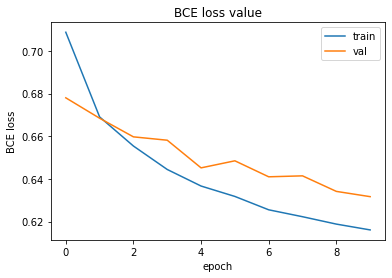

In [128]:
import matplotlib.pyplot as plt
plt.plot(losses)
plt.plot(losses_eval)
plt.title('BCE loss value')
plt.ylabel('BCE loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

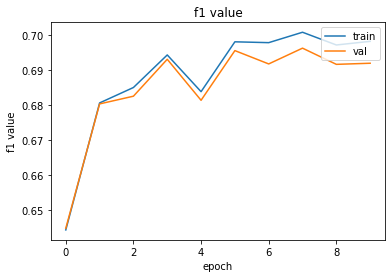

In [129]:
import matplotlib.pyplot as plt
plt.plot(f1s)
plt.plot(f1s_eval)
plt.title('f1 value')
plt.ylabel('f1 value')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [130]:
def predict(model, iterator):
    model.eval()
    fp = []
    fn = []
    tp = [] 
    tn = []
    with torch.no_grad():
        for i, (texts, ys) in enumerate(iterator):   
            preds = model(texts)  # делаем предсказания на тесте 
            for pred, gold, text in zip(preds, ys, texts):
                text = ''.join([id2word[int(word)] for word in text if word !=0])
                if round(pred.item()) > gold:
                    fp.append(text)
                elif round(pred.item()) < gold:
                    fn.append(text)
                elif round(pred.item()) == gold == 1:
                    tp.append(text)
                elif round(pred.item()) == gold == 0:
                    tn.append(text)
    return fp, fn, tp, tn

In [131]:
fp, fn, tp, tn = predict(model, val_iterator)

In [132]:
accuracy = (len(tp)+len(tn))/(len(tp)+len(fp)+len(fn)+len(tn))

In [133]:
accuracy

0.6396

In [134]:
precision = len(tp)/(len(tp)+len(fp))

In [135]:
precision

0.6097028958254983

In [136]:
recall = len(tp)/(len(tp)+len(fn))

In [137]:
recall

0.8005925925925926

# Вторая модель

In [94]:
symbol_vocab = Counter()
for symbol in all_tweets['text']:
    symbol_vocab.update(list(symbol))
print('всего уникальных символов:', len(symbol_vocab))

всего уникальных символов: 170


In [95]:
filtered_vocab = set()

for symbol in symbol_vocab:
    if symbol_vocab[symbol] > 5:
        filtered_vocab.add(symbol)
print('уникальных символов, втретившихся больше 5 раз:', len(filtered_vocab))

уникальных символов, втретившихся больше 5 раз: 86


In [96]:
symbol2id = {'PAD':0}

for symbol in filtered_vocab:
    symbol2id[symbol] = len(symbol2id)

In [97]:
id2symbol = {i:symbol for symbol, i in symbol2id.items()}

In [98]:
class TweetsSymbolsDataset(Dataset):

    def __init__(self, dataset, word2id, symbol2id, DEVICE):
        self.dataset = dataset['text'].values
        self.word2id = word2id
        self.symbol2id = symbol2id
        self.length = dataset.shape[0]
        self.target = dataset['label'].values
        self.device = DEVICE

    def __len__(self):
        return self.length

    def __getitem__(self, index): 
        words = list(self.dataset[index])
        symbols = list(self.dataset[index])
        ids_words = torch.LongTensor([self.word2id[word] for word in words if word in self.word2id])
        ids_symbols = torch.LongTensor([self.symbol2id[symbol] for symbol in symbols if symbol in self.symbol2id])
        y = [self.target[index]]
        return ids_words, ids_symbols, y

    def collate_fn(self, batch):
        ids_words, ids_symbols, y = list(zip(*batch))
        padded_ids_words = pad_sequence(ids_words, batch_first=True).to(self.device)
        padded_ids_symbols = pad_sequence(ids_symbols, batch_first=True).to(self.device)
        y = torch.Tensor(y).to(self.device)
        return padded_ids_words, padded_ids_symbols, y

In [99]:
train_dataset = TweetsSymbolsDataset(train_data, word2id, symbol2id, DEVICE)
train_sampler = RandomSampler(train_dataset)
train_iterator = DataLoader(train_dataset, collate_fn = train_dataset.collate_fn, sampler=train_sampler, batch_size=1024)

In [100]:
batch = next(iter(train_iterator))

In [101]:
batch[0].shape

torch.Size([1024, 90])

In [103]:
val_dataset = TweetsSymbolsDataset(val_data, word2id, symbol2id, DEVICE)
val_sampler = SequentialSampler(val_dataset)
val_iterator = DataLoader(val_dataset, collate_fn = val_dataset.collate_fn, sampler=val_sampler, batch_size=1024)

In [104]:
test_batch = next(iter(val_iterator))
test_batch[0].shape

torch.Size([1024, 102])

In [105]:
class CNNS(nn.Module):
    
    def __init__(self, vocab_size_words, vocab_size_symbols, embedding_dim_words, embedding_dim_symbols):
        super().__init__()
        self.embedding_words = nn.Embedding(vocab_size_words, embedding_dim_words)
        self.embedding_symbols = nn.Embedding(vocab_size_symbols, embedding_dim_symbols)
        self.bigrams_symbols = nn.Conv1d(in_channels=embedding_dim_symbols, out_channels=100, kernel_size=2, padding='same')
        self.trigrams_symbols = nn.Conv1d(in_channels=embedding_dim_symbols, out_channels=80, kernel_size=3, padding='same')
        self.pooling = nn.MaxPool1d(kernel_size=2, stride=2)
        self.relu = nn.ReLU()
        self.hidden = nn.Linear(in_features=181, out_features=1)
        self.hidden2 = nn.Linear(in_features=embedding_dim_words, out_features=1)
        self.dropout = nn.Dropout(p=0.5)
        self.out = nn.Sigmoid()

    def forward(self, word, symbol):
        
        embedded_words = self.embedding_words(word)
        embedded_symbols = self.embedding_symbols(symbol)
        
        embedded_words = torch.mean(embedded_words, dim=1)
        embedded_symbols = embedded_symbols.transpose(1,2)
        
        X = self.hidden2(embedded_words)

        feature_map_bigrams = self.dropout(self.pooling(self.relu(self.bigrams_symbols(embedded_symbols))))

        feature_map_trigrams = self.dropout(self.pooling(self.relu(self.trigrams_symbols(embedded_symbols))))


        pooling1 = feature_map_bigrams.max(2)[0] 

        pooling2 = feature_map_trigrams.max(2)[0]

        concat = torch.cat((pooling1, pooling2, X), 1)

        logits = self.hidden(concat) 
        logits = self.out(logits)      
        return logits

In [106]:
def train(model, iterator, optimizer, criterion):
    epoch_loss = 0 # для подсчета среднего лосса на всех батчах

    model.train()  # ставим модель в обучение, явно указываем, что сейчас надо будет хранить градиенты у всех весов

    for i, (words, symbols, ys) in enumerate(iterator): #итерируемся по батчам
        optimizer.zero_grad()  #обнуляем градиенты
        preds = model(words, symbols)   #прогоняем данные через модель
        loss = criterion(preds, ys) #считаем значение функции потерь  
        loss.backward() #считаем градиенты  
        optimizer.step() #обновляем веса 
        epoch_loss += loss.item() #сохраняем значение функции потерь
        if not (i + 1) % int(len(iterator)/5):
            print(f'Train loss: {epoch_loss/i}')      
    return  epoch_loss / len(iterator) # возвращаем среднее значение лосса по всей выборке

In [107]:
def evaluate(model, iterator, criterion):
    epoch_loss = 0
    epoch_metric = 0
    model.eval() 
    with torch.no_grad():
        for i, (words, symbols, ys) in enumerate(iterator):   
            preds = model(words, symbols)   # делаем предсказания на тесте
            loss = criterion(preds, ys)   # считаем значения функции ошибки для статистики  
            epoch_loss += loss.item()
            batch_metric = f1(preds.round().long(), ys.long(), ignore_index=0)
            epoch_metric += batch_metric

            if not (i + 1) % int(len(iterator)/5):
                print(f'Val loss: {epoch_loss/i}, Val f1: {epoch_metric/i}')
        
    return epoch_metric / len(iterator), epoch_loss / len(iterator) # возвращаем среднее значение по всей выборке

In [108]:
model = CNNS(len(word2id), len(symbol2id), 100, 8)
optimizer = optim.Adam(model.parameters(), lr=0.0005)
criterion = nn.BCELoss()  

model = model.to(DEVICE)
criterion = criterion.to(DEVICE)

In [109]:
losses = []
losses_eval = []
f1s = []
f1s_eval = []

for i in range(10):
    print(f'\nstarting Epoch {i}')
    print('Training...')
    epoch_loss = train(model, train_iterator, optimizer, criterion)
    losses.append(epoch_loss)
    print('\nEvaluating on train...')
    f1_on_train,_ = evaluate(model, train_iterator, criterion)
    f1s.append(f1_on_train)
    print('\nEvaluating on test...')
    f1_on_test, epoch_loss_on_test = evaluate(model, val_iterator, criterion)
    losses_eval.append(epoch_loss_on_test)
    f1s_eval.append(f1_on_test)


starting Epoch 0
Training...
Train loss: 0.7624250650405884
Train loss: 0.7256802916526794
Train loss: 0.7129198163747787
Train loss: 0.7050443342176534
Train loss: 0.6993128182114782

Evaluating on train...
Val loss: 0.7261485031672886, Val f1: 0.7217736840248108
Val loss: 0.701836411295266, Val f1: 0.693128228187561
Val loss: 0.6932575513016094, Val f1: 0.6879402995109558
Val loss: 0.6890051849817825, Val f1: 0.6856518983840942
Val loss: 0.6866453692719743, Val f1: 0.6835368275642395

Evaluating on test...
Val loss: 0.9043973286946615, Val f1: 0.9017200469970703
Val loss: 0.7753978456769671, Val f1: 0.7636064887046814
Val loss: 0.739358284256675, Val f1: 0.7338882684707642
Val loss: 0.7226108272870382, Val f1: 0.7183004021644592
Val loss: 0.7132284107961153, Val f1: 0.708351194858551

starting Epoch 1
Training...
Train loss: 0.7177381898675647
Train loss: 0.6917649939142424
Train loss: 0.6826983134854924
Train loss: 0.6769812137393628
Train loss: 0.6730192351985622

Evaluating on tr

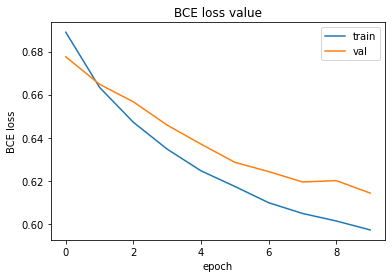

In [110]:
import matplotlib.pyplot as plt
plt.plot(losses)
plt.plot(losses_eval)
plt.title('BCE loss value')
plt.ylabel('BCE loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

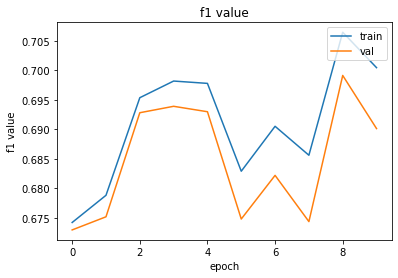

In [111]:
import matplotlib.pyplot as plt
plt.plot(f1s)
plt.plot(f1s_eval)
plt.title('f1 value')
plt.ylabel('f1 value')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()